In [12]:
import numpy as np
from scipy import optimize
import torch

class sstem_python():
    
    def __init__(self, f_stack):
        self.original_stack = f_stack
        self.original_shape = f_stack.shape
        self.original_pacbed = np.mean(self.original_stack, axis=(0, 1))
        
        print("the shape of the data =", self.original_shape)
        
        if torch.cuda.is_available():
            print("%d gpu available"%(torch.cuda.device_count()))
            self.cuda_device = torch.device("cuda:0")
            print(torch.cuda.get_device_name(self.cuda_device))
            torch.cuda.set_device(self.cuda_device)
        else:
            self.cuda_device = None
    
    def find_center(self, com=True, gaussian=False):
        
        if com and gaussian:
            print("Warning! Choose only one option to find the center")
        
        if not com and not gaussian:
            print("Warning! Choose at least one option to find the center")
        
        Y, X = np.indices(self.original_pacbed.shape)
        com_y = np.sum(self.original_pacbed * Y) / np.sum(self.original_pacbed)
        com_x = np.sum(self.original_pacbed * X) / np.sum(self.original_pacbed)
        self.com_ct = [com_y, com_x]
        
        (_, center_y, center_x, _, _) = fitgaussian(self.original_pacbed)
        self.gauss_ct = [center_y, center_x]
        
        if com:
            self.ct=self.com_ct
        
        else:
            self.ct=self.gauss_ct
        
    def disk_extract(self, buffer_size=0):
        grad = np.gradient(self.original_pacbed)
        grad_map = grad[0]**2 + grad[1] **2
        grad_map = grad_map / np.max(grad_map)
        
        max_ind = np.unravel_index(np.argmax(grad_map, axis=None), grad_map.shape)
        self.least_R = ((max_ind[0]-self.ct[0])**2 + (max_ind[1]-self.ct[1])**2)**(1/2)
        
        self.ct_ind  = np.around(self.ct).astype(int) #np.int
        self.cropped_size = np.around(self.least_R + buffer_size).astype(int) #np.int
        
        if self.cropped_size > self.ct_ind[0] or self.cropped_size > self.ct_ind[1]:
            self.cropped_size = np.min(ct_ind)
        
        self.c_ct = [self.cropped_size, self.cropped_size]
        self.c_stack = self.original_stack[:, :, self.ct_ind[0]-self.cropped_size:self.ct_ind[0]+self.cropped_size+1, 
                               self.ct_ind[1]-self.cropped_size:self.ct_ind[1]+self.cropped_size+1].copy()
        self.c_shape = self.c_stack.shape
        self.c_pacbed = np.mean(self.c_stack, axis=(0, 1))
        
    def virtual_stem(self, BF, ADF, mrad_per_pixel=1):
        self.BF_detector = radial_indices(self.original_pacbed.shape, BF, mrad_per_pixel, center=self.ct)
        self.BF_stem = np.sum(np.multiply(self.original_stack, self.BF_detector), axis=(2, 3))
        
        self.ADF_detector = radial_indices(self.original_pacbed.shape, ADF, mrad_per_pixel, center=self.ct)
        self.ADF_stem = np.sum(np.multiply(self.original_stack, self.ADF_detector), axis=(2, 3))
        
    def symmetry_evaluation(self, angle, also_mirror=False):
        rotation_stack = []
        r_correl = np.zeros(self.original_shape[:2])
        m_correl = np.zeros(self.original_shape[:2])
        
        ri = radial_indices(self.c_pacbed.shape, [0, self.cropped_size], 1, center=self.c_ct)
        
        for i in range(self.original_shape[0]):
            for j in range(self.original_shape[1]):
                tmp_dp = self.c_stack[i,j,:,:].copy()
                newdata = rotation(tmp_dp, self.c_ct, angle, torch_device=self.cuda_device)
                newdata = np.multiply(newdata, ri)
                rotation_stack.append(newdata)
                r_correl[i,j] = correlation(tmp_dp/np.max(tmp_dp), newdata)
                
                if also_mirror:
                    m_correl[i, j] = mirror(newdata, self.c_ct)
        
        rotation_stack = np.asarray(rotation_stack).reshape(self.c_shape)
        
        return rotation_stack, r_correl, m_correl
    

def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape) # row, col
    x = (X*data).sum()/total # row
    y = (Y*data).sum()/total # col
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum()) # row
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum()) # col
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

def radial_indices(shape, radial_range, scale, center=None):
    y, x = np.indices(shape)
    if not center:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
    
    r = np.hypot(y - center[0], x - center[1]) * scale
    ri = np.ones(r.shape)
    
    if len(np.unique(radial_range)) > 1:
        ri[np.where(r < radial_range[0])] = 0
        ri[np.where(r > radial_range[1])] = 0
        
    else:
        r = np.round(r)
        ri[np.where(r != round(radial_range[0]))] = 0
    
    return ri

def correlation(dat2d, newdata):
    # return correlation value
    dat1d = dat2d.flatten()
    new1d = newdata.flatten()
    correlation = np.correlate(dat1d, new1d)

    return correlation[0]

def rotation(data, center, angle, torch_device=None):
    #Use crop image #Input : 2d data, angle(degree) /return : 2d data
    angle = angle * np.pi/180
    newdata = np.zeros(data.shape)
    alpha, beta = np.cos(angle), np.sin(angle)
    
    M = np.array([[alpha, beta, (1-alpha)*center[1]-beta*center[0]], 
         [-beta, alpha, beta*center[1]+(1-alpha)*center[0]]])
    
    y, x = np.indices(data.shape)
    ones = np.ones(data.shape)
    y = y[:, :, np.newaxis]
    x = x[:, :, np.newaxis]
    ones = ones[:, :, np.newaxis]
    ind_stack = np.stack((y, x, ones), axis=2)
    
    if torch_device != None:
        M = torch.from_numpy(M)
        M = M.to(torch_device)
        ind_stack = torch.from_numpy(ind_stack)
        ind_stack = ind_stack.to(torch_device)
    
    transformed_ind = M @ ind_stack
    if torch_device != None:
        transformed_ind = transformed_ind.cpu().numpy()
    transformed_ind = np.around(transformed_ind.squeeze()).astype(int)
    transformed_ind[np.where(transformed_ind>=np.max(data.shape))] = 0
    
    transformed_y = transformed_ind[:, :, 0].flatten()
    transformed_x = transformed_ind[:, :, 1].flatten()
    
    newdata[transformed_y, transformed_x] = data.flatten()
                
    return newdata/np.max(newdata)

def mirror(data, center):
    #Input data : 2d # Return : Correlation value
    data1 = data[:, :center[1]-1]
    data2 = np.flip(data, axis=1)[:, :center[1]-1]
    value = correlation(data1, data2)        
    
    return value

In [2]:
import tifffile
import matplotlib.pyplot as plt
import tkinter.filedialog as tkf
import time

In [3]:
raw_adr = tkf.askopenfilename()
print(raw_adr)

E:/data_temporary/20210520_SSTEM_example/LAST_256x256.tif


In [4]:
f_stack = tifffile.imread(raw_adr)
print(f_stack.shape)
print(f_stack.dtype)

(256, 256, 128, 128)
float32


In [5]:
f_stack = f_stack[:64, :64]

the shape of the data = (64, 64, 128, 128)
1 gpu available
GeForce GTX 960


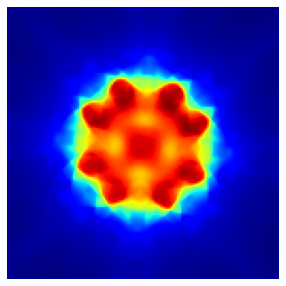

In [6]:
test = sstem_python(f_stack)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(test.original_pacbed, cmap="jet")
ax.axis("off")
plt.show()

[64.20283477931589, 63.53388105533672]


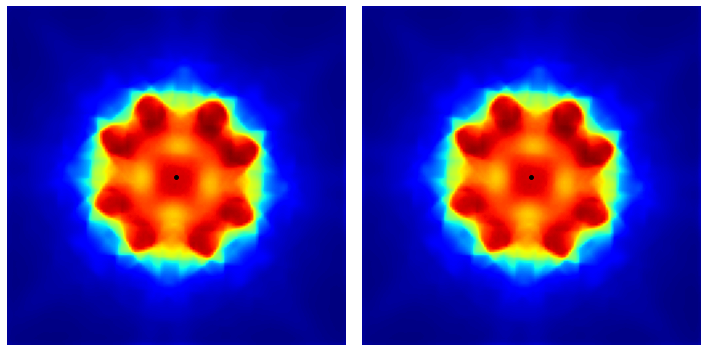

In [7]:
test.find_center(com=True, gaussian=False)
print(test.ct)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(test.original_pacbed, cmap="jet")
ax[0].axis("off")
ax[0].scatter(test.com_ct[1], test.com_ct[0], s=15, c="k")
ax[1].imshow(test.original_pacbed, cmap="jet")
ax[1].axis("off")
ax[1].scatter(test.gauss_ct[1], test.gauss_ct[0], s=15, c="k")
fig.tight_layout()
plt.show()

(64, 64, 87, 87)


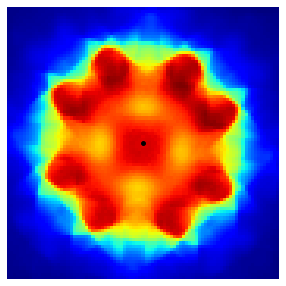

(87, 87)
33.224531707348525


In [8]:
test.disk_extract(buffer_size=10)
print(test.c_stack.shape)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(test.c_pacbed, cmap="jet")
ax.scatter(test.c_ct[1], test.c_ct[0], s=15, c="k")
ax.axis("off")
plt.show()
print(test.c_pacbed.shape)
print(test.least_R)

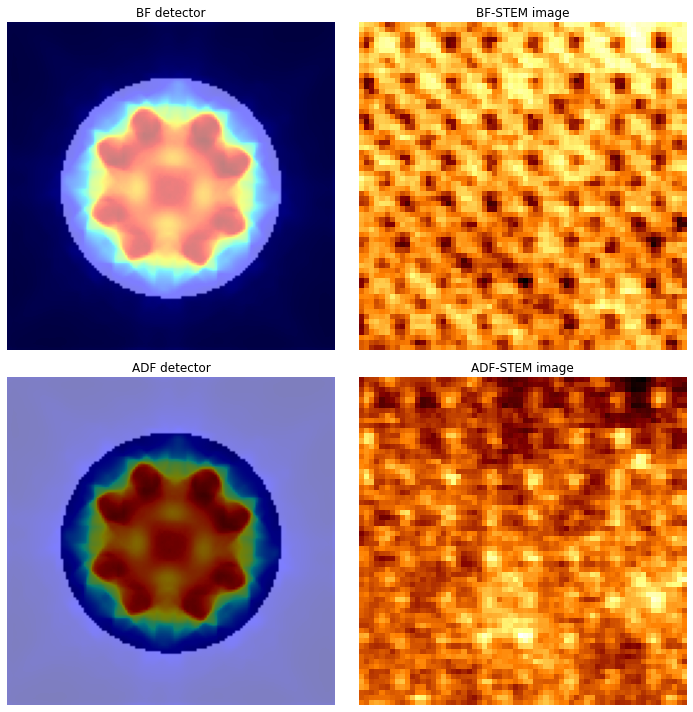

In [9]:
BF_det = [0, test.cropped_size]
ADF_det = [test.cropped_size, 100]
mrad_per_pixel = 1
test.virtual_stem(BF_det, ADF_det, mrad_per_pixel)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].imshow(test.original_pacbed, cmap="jet")
ax[0][0].imshow(test.BF_detector, cmap="gray", alpha=0.5)
ax[0][0].set_title("BF detector")
ax[0][0].axis("off")
ax[0][1].imshow(test.BF_stem, cmap="afmhot")
ax[0][1].set_title("BF-STEM image")
ax[0][1].axis("off")
ax[1][0].imshow(test.original_pacbed, cmap="jet")
ax[1][0].imshow(test.ADF_detector, cmap="gray", alpha=0.5)
ax[1][0].set_title("ADF detector")
ax[1][0].axis("off")
ax[1][1].imshow(test.ADF_stem, cmap="afmhot")
ax[1][1].set_title("ADF-STEM image")
ax[1][1].axis("off")
fig.tight_layout()
plt.show()

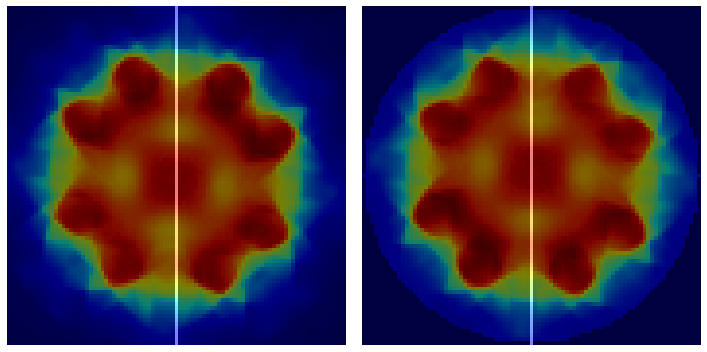

In [18]:
rotated_pacbed = rotation(test.c_pacbed, test.c_ct, 180, torch_device=test.cuda_device)
ri = radial_indices(test.c_pacbed.shape, [0, test.cropped_size], 1, center=test.c_ct)
mirror_plane = np.zeros(rotated_pacbed.shape)
mirror_plane[:, test.c_ct[1]] = 1
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(test.c_pacbed, cmap="jet")
ax[0].imshow(mirror_plane, cmap="gray", alpha=0.5)
ax[0].axis("off")
ax[1].imshow(np.multiply(rotated_pacbed, ri), cmap="jet")
ax[1].imshow(mirror_plane, cmap="gray", alpha=0.5)
ax[1].axis("off")
fig.tight_layout()
plt.show()

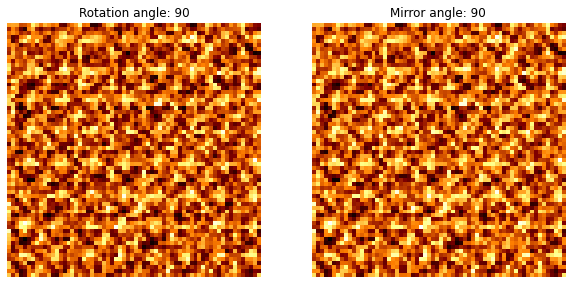

Working time : 4.840767860412598 sec


In [13]:
start = time.time()
rot_angle = 90
rot_60_stack, rot_sym_img, mir_sym_img = test.symmetry_evaluation(rot_angle, also_mirror=True)
f, a = plt.subplots(1,2, figsize=(10,5))
a[0].imshow(rot_sym_img, cmap="afmhot")
a[0].set_title("Rotation angle: {}".format(rot_angle))
a[0].axis("off")
a[1].imshow(mir_sym_img, cmap="afmhot")
a[1].set_title("Mirror angle: {}".format(rot_angle))
a[1].axis("off")
plt.show()
print("Working time : {} sec".format(time.time()-start))

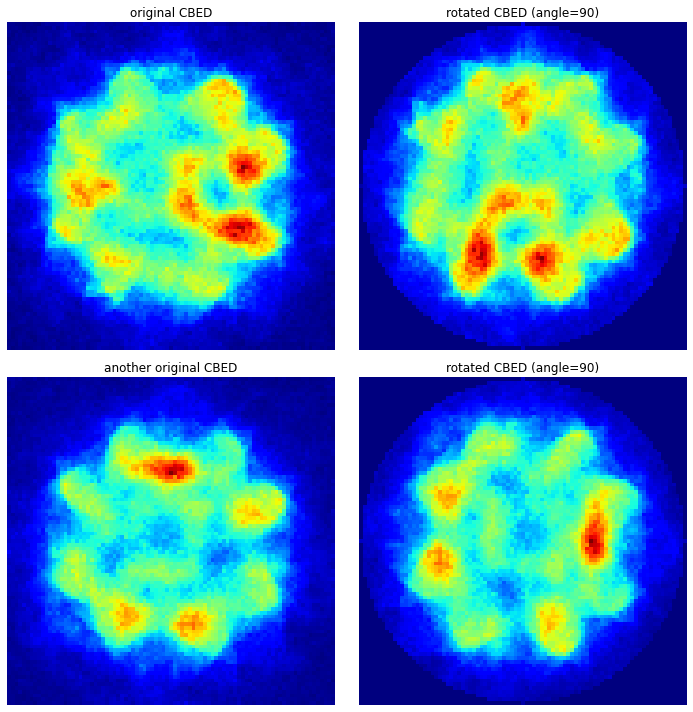

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].imshow(test.c_stack[0, 0], cmap="jet")
ax[0][0].set_title("original CBED")
ax[0][0].axis("off")
ax[0][1].imshow(rot_60_stack[0, 0], cmap="jet")
ax[0][1].set_title("rotated CBED (angle=%d)"%rot_angle)
ax[0][1].axis("off")
ax[1][0].imshow(test.c_stack[5, 5], cmap="jet")
ax[1][0].set_title("another original CBED")
ax[1][0].axis("off")
ax[1][1].imshow(rot_60_stack[5, 5], cmap="jet")
ax[1][1].set_title("rotated CBED (angle=%d)"%rot_angle)
ax[1][1].axis("off")
fig.tight_layout()
plt.show()